![](../img/330-banner.png)

# Lecture 20: Time series

UBC 2024-25

![](../img/time-series-dall-e.png)

The picture is created using DALL-E! 

> This illustration shows a cityscape with skyscrapers, each featuring digital billboards displaying time-series graphs. These graphs represent various types of data such as stock market trends, weather patterns, and population growth, set against the backdrop of a bustling city with people of diverse descents and genders. This setting should provide a compelling and relatable context for your introduction to time-series lecture.

## Imports and LO

### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")

### Learning objectives

- Recognize when it is appropriate to use time series. 
- Explain the pitfalls of train/test splitting with time series data.
- Appropriately split time series data, both train/test split and cross-validation.
- Perform time series feature engineering:
  - Encode time as various features in a tabular dataset 
  - Create lag-based features
- Explain how can you forecast multiple time steps into the future.
- Explain the challenges of time series data with unequally spaced time points.
- At a high level, explain the concept of trend.

<br><br>

## Motivation

- **Time series** is a collection of data points indexed in time order. 
- Time series is everywhere:
    - Physical sciences (e.g., weather forecasting)  
    - Economics, finance (e.g., stocks, market trends)
    - Engineering (e.g., energy consumption)
    - Social sciences 
    - Sports analytics

Let's start with a simple example from [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/). 

In New York city there is a network of bike rental stations with a subscription system. The stations are all around the city. The anonymized data is available [here](https://ride.citibikenyc.com/system-data).

We will focus on the task is predicting how many people will rent a bicycle from a particular station for a given time and day. We might be interested in knowing this so that we know whether there will be any bikes left at the station for a particular day and time.  

In [2]:
import mglearn

citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3h, Name: one, dtype: int64

- The only feature we have is the date time feature. 
    - Example: 2015-08-01 00:00:00
- What's the duration of the intervals? 
    - The data is collected at regular intervals (every three hours) 
- The target is the number of rentals in the next 3 hours. 
    - Example: 3 rentals between 2015-08-01 00:00:00 and 2015-08-01 03:00:00  

<br><br>

- We have a time-ordered sequence of data points.
- This type of data is distinctive because it is inherently sequential, with an intrinsic order based on time.
- The number of bikes available at a station at one point in time is often related to the number of bikes at earlier times. 
- This is a **time-series forecasting** problem.

Let's check the time duration of our data. 

In [3]:
citibike.index.min()

Timestamp('2015-08-01 00:00:00')

In [4]:
citibike.index.max()

Timestamp('2015-08-31 21:00:00')

We have data for August 2015. Let's visualize our data. 

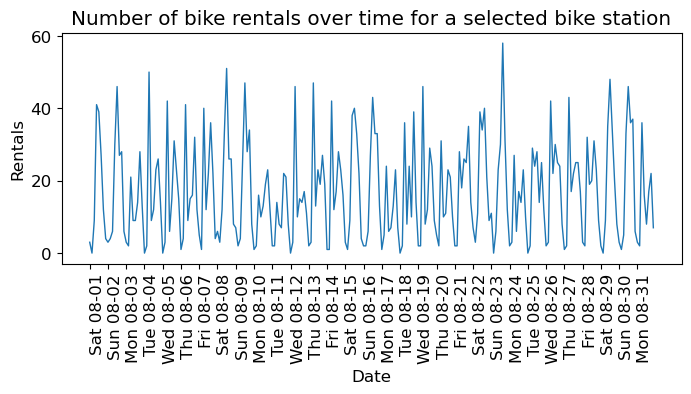

In [5]:
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq="D")
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");
plt.title("Number of bike rentals over time for a selected bike station");

- We see the day and night pattern
- We see the weekend and weekday pattern 

- Questions you might want to answer: How many people are likely to rent a bike at this station in the next three hours given everything we know about rentals in the past? 
- We want to learn from the past and predict the future. 

### ❓❓ Questions for you

- Can we use our usual supervised machine learning methodology to predict the number of people who will rent bicycles from a specific station at a given time and date?
- How can you adapt traditional machine learning methods for time series forecasting?


<br><br><br><br><br><br><br><br>

## Train/test split for temporal data

- To evaluate the model's ability to generalize, we will divide the data into training and testing subsets.
- What will happen if we split this data the usual way?

In [6]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [7]:
test_df.head()

starttime
2015-08-26 12:00:00    30
2015-08-12 09:00:00    10
2015-08-19 03:00:00     2
2015-08-07 12:00:00    22
2015-08-03 09:00:00     9
Name: one, dtype: int64

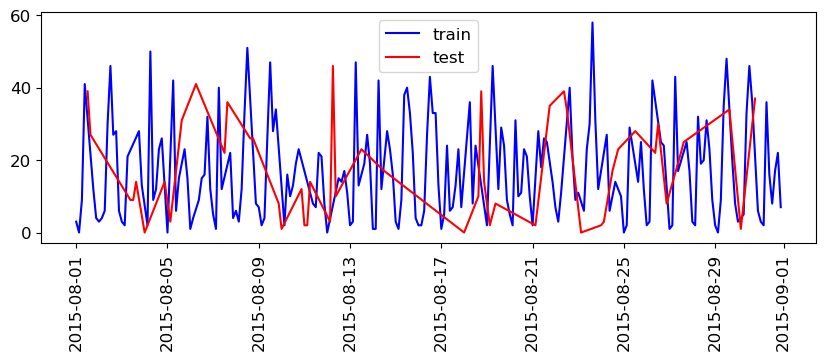

In [8]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

In [9]:
train_df.index.max()

Timestamp('2015-08-31 21:00:00')

In [10]:
test_df.index.min()

Timestamp('2015-08-01 12:00:00')

- We are training on data that came after our test data!
- If we want to forecast, **we aren't allowed to know what happened in the future**!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

We'll split the data as follows:

- We have total 248 data points. 
- We'll use the fist 184 data points corresponding to the first 23 days as training data - And the remaining 64 data points corresponding to the remaining 8 days as test data. 

In [11]:
citibike.shape

(248,)

In [12]:
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

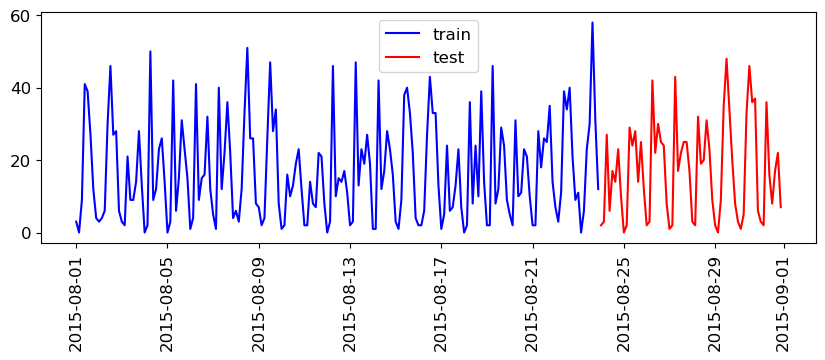

In [13]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

This split is looking reasonable now. We'll train our model on the blue part and evaluate it on the red part. 

<br><br>

## Feature engineering for date/time columns

### ❓❓ Questions for you

- What kind of features would you create from time series data to use in a model like a random forest or SVM?

<br><br><br><br><br><br><br><br>

### POSIX time feature
- In this toy data, we just have a single feature: the date time feature. 
- We need to encode this feature if we want to build machine learning models. 
- A common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time). 
- Let's start with encoding this feature as a single integer representing this POSIX time. 

In [15]:
X = (
    citibike.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
)  # convert to POSIX time by dividing by 10**9
y = citibike.values

```{admonition} Note 
:class: note
In pandas, datetime objects are typically represented as Timestamp objects, which internally store time as the number of nanoseconds (1 billionth of a second. 1 second = $10^9$ nanoseconds) since the POSIX epoch (January 1, 1970, 00:00:00 UTC).
```

In [16]:
y_train = train_df.values
y_test = test_df.values
# convert to POSIX time by dividing by 10**9
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9

In [17]:
X_train[:10]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400]], dtype=int64)

In [18]:
y_train[:10]

array([ 3,  0,  9, 41, 39, 27, 12,  4,  3,  4], dtype=int64)

- Our prediction task is a regression task. 

- Let's try random forest regression with just this feature. 
- We'll be trying out many different features. So we'll be using the function below which
    - Splits the data 
    - Trains the given regressor model on the training data
    - Shows train and test scores
    - Plots the predictions on the train and test data

In [19]:
# Code credit: Adapted from 
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

def eval_on_features(features, target, regressor, n_train=184, sales_data=False, 
                     ylabel='Rentals', 
                     feat_names="Default", 
                     impute=True):
    """
    Evaluate a regression model on a given set of features and target.

    This function splits the data into training and test sets, fits the 
    regression model to the training data, and then evaluates and plots 
    the performance of the model on both the training and test datasets.

    Parameters:
    -----------
    features : array-like
        Input features for the model.
    target : array-like
        Target variable for the model.
    regressor : model object
        A regression model instance that follows the scikit-learn API.
    n_train : int, default=184
        The number of samples to be used in the training set.
    sales_data : bool, default=False
        Indicates if the data is sales data, which affects the plot ticks.
    ylabel : str, default='Rentals'
        The label for the y-axis in the plot.
    feat_names : str, default='Default'
        Names of the features used, for display in the plot title.
    impute : bool, default=True
        whether SimpleImputer needs to be applied or not

    Returns:
    --------
    None
        The function does not return any value. It prints the R^2 score
        and generates a plot.
    """

    # Split the features and target data into training and test sets
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    if impute:
        simp = SimpleImputer()
        X_train = simp.fit_transform(X_train)
        X_test = simp.transform(X_test)
    
    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Print R^2 scores for training and test datasets
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    # Predict target variable for both training and test datasets
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    # Plotting
    plt.figure(figsize=(10, 3))

    # If not sales data, adjust x-ticks for dates (assumes datetime format)
    if not sales_data: 
        plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")

    # Plot training and test data, along with predictions
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test")

    # Set plot title, labels, and legend
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

Let's try random forest regressor with our posix time feature. 

Train-set R^2: 0.85
Test-set R^2: -0.04


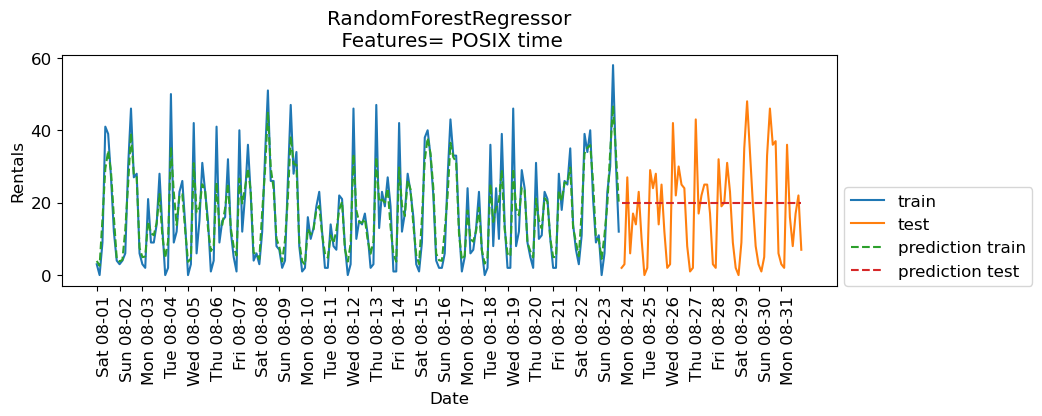

In [20]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor, feat_names="POSIX time")

- The predictions on the training data and training score are pretty good 
- But for the test data, a constant line is predicted ...
- What's going on?
<br><br><br><br>

- The model is based on only one feature: POSIX time feature. 
- And the value of the POSIX time feature is outside the range of the feature values in the training set. 
- Tree-based models cannot _extrapolate_ to feature ranges outside the training data. 
- The model predicted the target value of the closest point in the training set. 

Can we come up with better features? 

### Extracting date and time information 

- Note that our index is of this special type: [`DateTimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html). We can extract all kinds of interesting information from it.   

In [21]:
citibike.index

DatetimeIndex(['2015-08-01 00:00:00', '2015-08-01 03:00:00',
               '2015-08-01 06:00:00', '2015-08-01 09:00:00',
               '2015-08-01 12:00:00', '2015-08-01 15:00:00',
               '2015-08-01 18:00:00', '2015-08-01 21:00:00',
               '2015-08-02 00:00:00', '2015-08-02 03:00:00',
               ...
               '2015-08-30 18:00:00', '2015-08-30 21:00:00',
               '2015-08-31 00:00:00', '2015-08-31 03:00:00',
               '2015-08-31 06:00:00', '2015-08-31 09:00:00',
               '2015-08-31 12:00:00', '2015-08-31 15:00:00',
               '2015-08-31 18:00:00', '2015-08-31 21:00:00'],
              dtype='datetime64[ns]', name='starttime', length=248, freq='3h')

In [22]:
citibike.index.month_name()

Index(['August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August',
       ...
       'August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August'],
      dtype='object', name='starttime', length=248)

In [23]:
citibike.index.dayofweek

Index([5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       ...
       6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype='int32', name='starttime', length=248)

In [24]:
citibike.index.day_name()

Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Sunday', 'Sunday',
       ...
       'Sunday', 'Sunday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object', name='starttime', length=248)

In [25]:
citibike.index.hour

Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
       ...
       18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
      dtype='int32', name='starttime', length=248)

- We noted before that the time of the day and day of the week seem quite important. 
- Let's add these two features. 

Let's first add the time of the day. 

In [26]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour[:10]

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12],
       [15],
       [18],
       [21],
       [ 0],
       [ 3]])

Train-set R^2: 0.50
Test-set R^2: 0.60


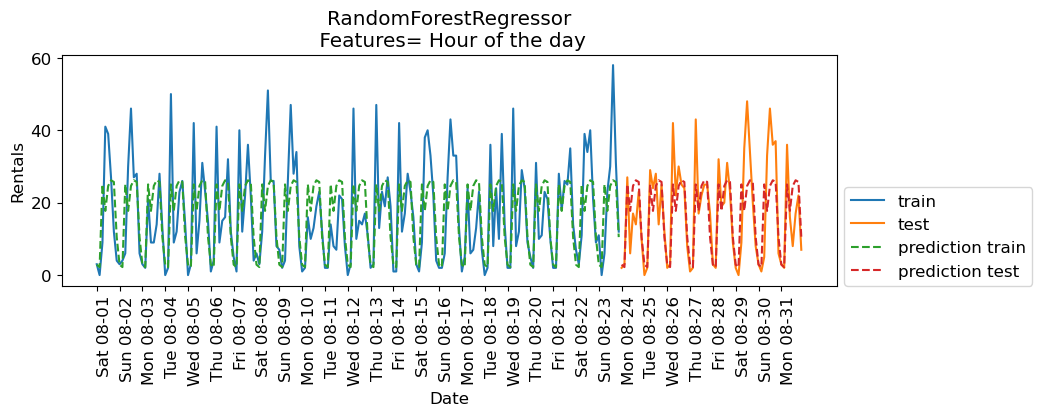

In [27]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor, feat_names = "Hour of the day")

The scores are better when we add time of the day feature. 

Now let's add day of the week along with time of the day. 

Train-set R^2: 0.89
Test-set R^2: 0.84


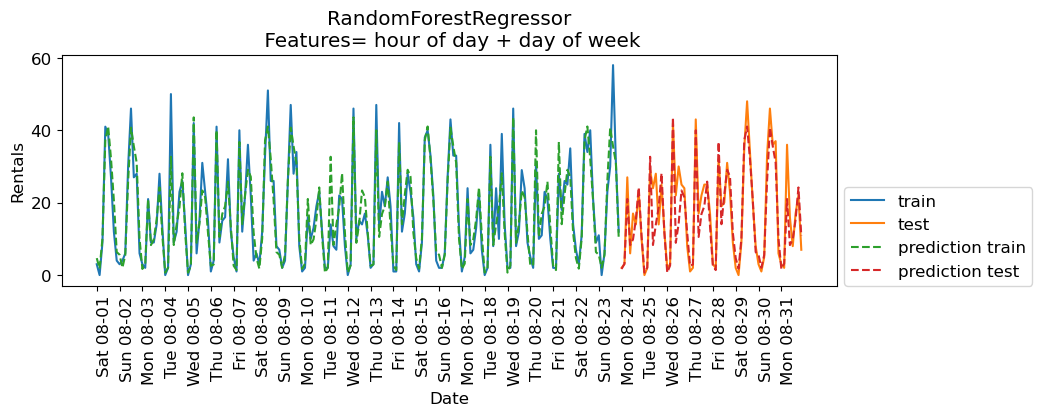

In [28]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
X_hour_week = np.hstack(
    [
        citibike.index.dayofweek.values.reshape(-1, 1),
        citibike.index.hour.values.reshape(-1, 1),
    ]
)
eval_on_features(X_hour_week, y, regressor, feat_names = "hour of day + day of week")

The results are much better. The time of the day and day of the week features are clearly helping. 

- Do we need a complex model such as a random forest? 
- Let's try `Ridge` with these features.

Train-set R^2: 0.16
Test-set R^2: 0.13


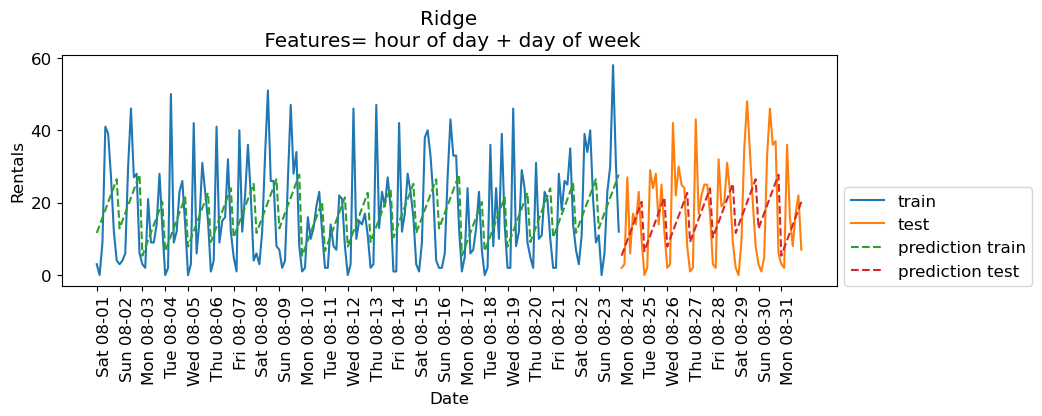

In [29]:
from sklearn.linear_model import Ridge

lr = Ridge();
eval_on_features(X_hour_week, y, lr, feat_names = "hour of day + day of week")

### ❓❓ Questions for you

- Why is `Ridge` performing poorly on the training data as well as test data? 

<br><br><br><br><br><br><br><br>

### Encoding time of day as a categorical feature

- `Ridge` is performing poorly because it's not able to capture the periodic pattern.
- The reason is that we have encoded time of day using integers. 
- A linear function can only learn a linear function of the time of day. 
- What if we encode this feature as a categorical variable? 

In [30]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [31]:
X_hour_week_onehot
X_hour_week_onehot.shape

(248, 15)

In [32]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

In [33]:
pd.DataFrame(X_hour_week_onehot, columns=features)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train-set R^2: 0.53
Test-set R^2: 0.62


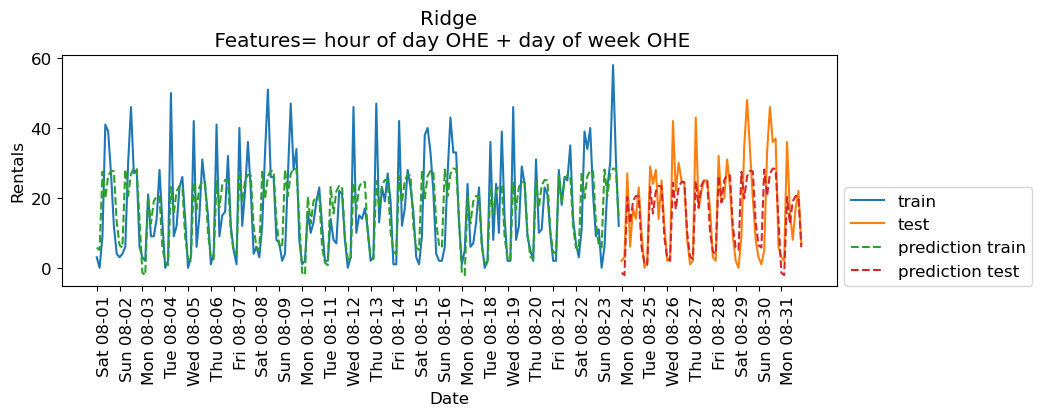

In [34]:
eval_on_features(X_hour_week_onehot, y, Ridge(), feat_names="hour of day OHE + day of week OHE")

- The scores are a bit better now. 
- What if we add interaction features (e.g., something like Day == Mon and hour == 9:00)
- We can do it using `sklearn`'s `PolynomialFeatures` transformer. 

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False
)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

In [36]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour
features_poly = poly_transformer.get_feature_names_out(features)
features_poly

array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00',
       '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', 'Mon Tue',
       'Mon Wed', 'Mon Thu', 'Mon Fri', 'Mon Sat', 'Mon Sun', 'Mon 00:00',
       'Mon 03:00', 'Mon 06:00', 'Mon 09:00', 'Mon 12:00', 'Mon 15:00',
       'Mon 18:00', 'Mon 21:00', 'Tue Wed', 'Tue Thu', 'Tue Fri',
       'Tue Sat', 'Tue Sun', 'Tue 00:00', 'Tue 03:00', 'Tue 06:00',
       'Tue 09:00', 'Tue 12:00', 'Tue 15:00', 'Tue 18:00', 'Tue 21:00',
       'Wed Thu', 'Wed Fri', 'Wed Sat', 'Wed Sun', 'Wed 00:00',
       'Wed 03:00', 'Wed 06:00', 'Wed 09:00', 'Wed 12:00', 'Wed 15:00',
       'Wed 18:00', 'Wed 21:00', 'Thu Fri', 'Thu Sat', 'Thu Sun',
       'Thu 00:00', 'Thu 03:00', 'Thu 06:00', 'Thu 09:00', 'Thu 12:00',
       'Thu 15:00', 'Thu 18:00', 'Thu 21:00', 'Fri Sat', 'Fri Sun',
       'Fri 00:00', 'Fri 03:00', 'Fri 06:00', 'Fri 09:00', 'Fri 12:00',
       'Fri 15:00', 'Fri 18:00', 'Fri 21:00', 'Sat Sun', 'Sat 00:00',
       'Sat 03:00

In [37]:
df_hour_week_ohe_poly = pd.DataFrame(X_hour_week_onehot_poly, columns = features_poly)
df_hour_week_ohe_poly

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,...,09:00 12:00,09:00 15:00,09:00 18:00,09:00 21:00,12:00 15:00,12:00 18:00,12:00 21:00,15:00 18:00,15:00 21:00,18:00 21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_hour_week_onehot_poly.shape

(248, 120)

Train-set R^2: 0.87
Test-set R^2: 0.85


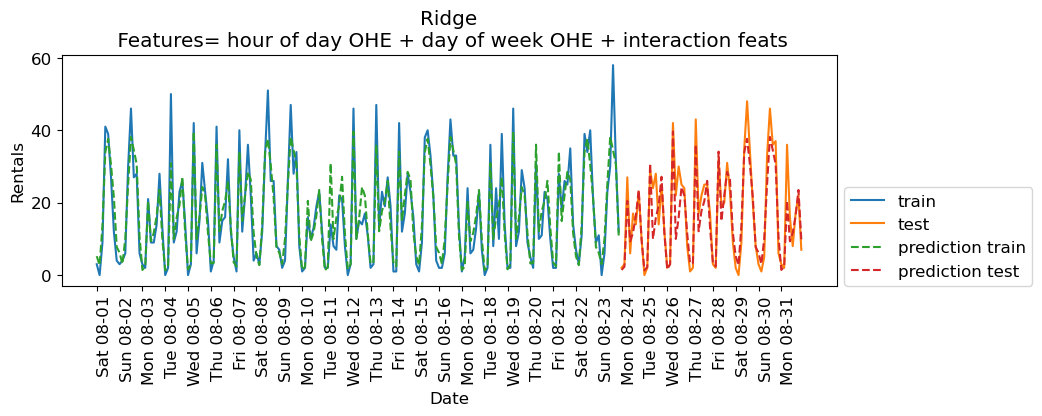

In [39]:
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr, feat_names = "hour of day OHE + day of week OHE + interaction feats")

The scores are much better now. Since we are using a linear model, we can examine the coefficients learned by `Ridge`. 

In [40]:
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [41]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
Sat 09:00,15.196739
Wed 06:00,15.005809
Sat 12:00,13.437684
Sun 12:00,13.362009
Thu 06:00,10.907595
...,...
Sat 21:00,-6.085150
00:00,-11.693898
03:00,-12.111220
Sat 06:00,-13.757591


- The coefficients make sense!
- If it's Saturday 09:00 or Wednesday 06:00, the model is likely to predict bigger number for rentals. 
- If it's Midnight or 03:00 or Sunday 06:00, the model is likely to predict smaller number for rentals. 

### Interim summary

- Success in time-series analysis heavily relies on the appropriate choice of models and features.
- Tree-based models cannot extrapolate; caution is needed when using them with linear integer features.
- Linear models struggle with cyclic patterns in numeric features (e.g., numerically encoded time of the day feature) because these patterns are inherently non-linear.
- Applying one-hot encoding on such features transforms cyclic temporal features into a format where their impact on the target variable can be independently and linearly modeled, enabling linear models to effectively capture and use these cyclic patterns. 

<br><br>

## Lag-based features

- So far we engineered some features and managed to get reasonable results. 
- In time series data there is temporal dependence; observations close in time tend to be correlated. 
- Currently we're using current time to predict the number of bike rentals in the next three hours. 
- But, what if the number of bike rentals is also related to bike rentals three hours ago or 6 hours ago and so on? 
  - Such features are called _lagged_ features.  
  
_Note: In time series analysis, you would look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here._ 

Let's extract lag features. We can "lag" (or "shift") a time series in Pandas with the `.shift()` method.

In [42]:
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3h, Name: one, Length: 248, dtype: int64

In [43]:
rentals_df = pd.DataFrame(citibike)
rentals_df = rentals_df.rename(columns={"one":"n_rentals"})
rentals_df

,n_rentals
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39
...,...
2015-08-31 09:00:00,16
2015-08-31 12:00:00,8
2015-08-31 15:00:00,17


In [44]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [45]:
rentals_lag5 = create_lag_df(rentals_df, 5, ['n_rentals'] )

In [46]:
rentals_lag5

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
...,...,...,...,...,...,...
2015-08-31 09:00:00,16,36.0,2.0,3.0,6.0,37.0
2015-08-31 12:00:00,8,16.0,36.0,2.0,3.0,6.0
2015-08-31 15:00:00,17,8.0,16.0,36.0,2.0,3.0


- Note the NaN pattern. 
- We can either drop the first 5 rows or apply imputation. 
- Let's try these features with `Ridge` model.

In [47]:
X_lag_features = rentals_lag5.drop(columns = ['n_rentals']).to_numpy()
X_lag_features

array([[nan, nan, nan, nan, nan],
       [ 3., nan, nan, nan, nan],
       [ 0.,  3., nan, nan, nan],
       ...,
       [ 8., 16., 36.,  2.,  3.],
       [17.,  8., 16., 36.,  2.],
       [22., 17.,  8., 16., 36.]])

Train-set R^2: 0.25
Test-set R^2: 0.37


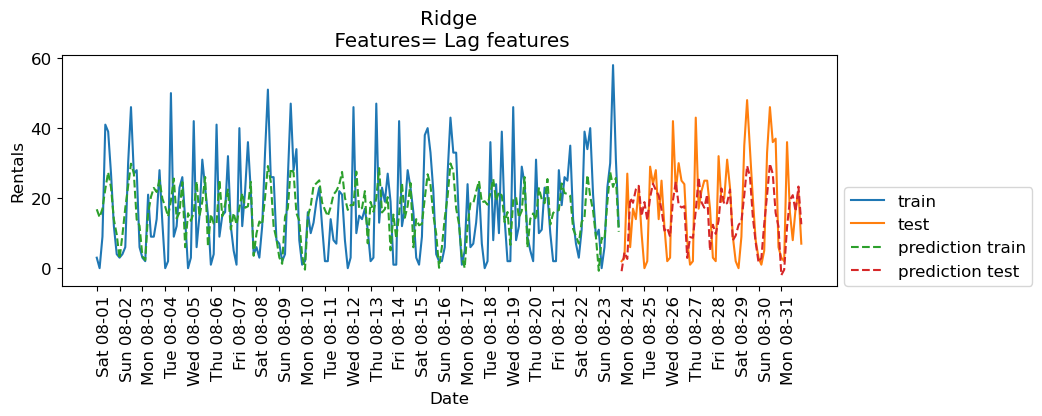

In [48]:
lr = Ridge()
eval_on_features(X_lag_features, y, lr, feat_names="Lag features", impute="yes")

The results are not great. But let's examine the coefficients. 

In [49]:
features_lag = rentals_lag5.drop(columns=['n_rentals']).columns.tolist()
features_nonzero = np.array(features_lag)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [50]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
n_rentals-1,0.165617
n_rentals-4,-0.048630
n_rentals-2,-0.214821
n_rentals-3,-0.258225
n_rentals-5,-0.373656


How about `RandomForestRegressor` model? 

Train-set R^2: 0.94
Test-set R^2: 0.69


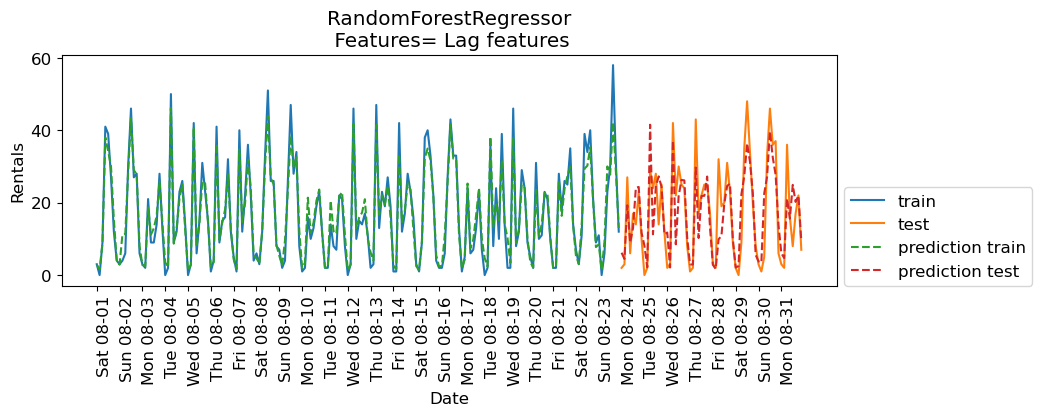

In [51]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
rf = RandomForestRegressor()
eval_on_features(X_lag_features_imp, y, rf, feat_names="Lag features")

The results are better than `Ridge` with lag features but they are not as good as the results with our previously engineered features. How about combining lag-based features and the previously extracted features? 

In [52]:
X_hour_week_onehot_poly_lag = np.hstack([X_hour_week_onehot_poly, X_lag_features])

Train-set R^2: 0.95
Test-set R^2: 0.78


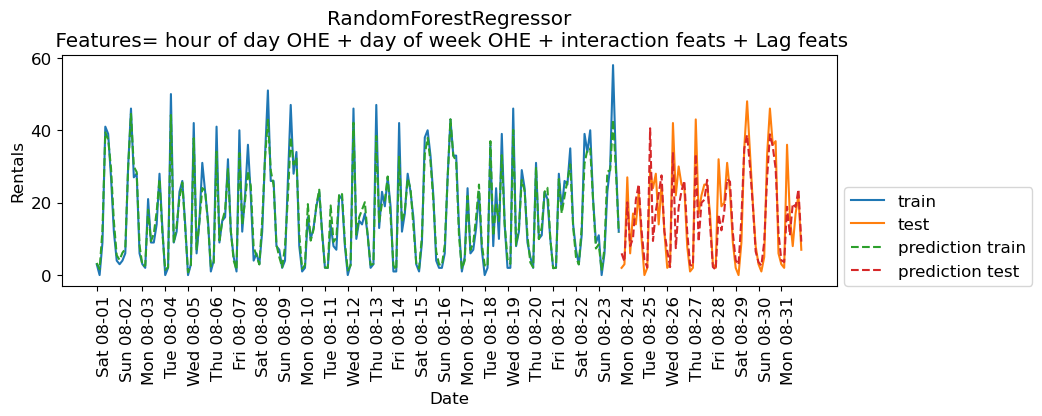

In [53]:
rf = RandomForestRegressor()
eval_on_features(X_hour_week_onehot_poly_lag, y, rf, feat_names = "hour of day OHE + day of week OHE + interaction feats + Lag feats")

Some improvement but we are getting better results without the lag features in this case. 

### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- If you carry out regular cross-validation, as shown below, you'll be predicting the past given future which is not a realistic scenario for the deployment data. 

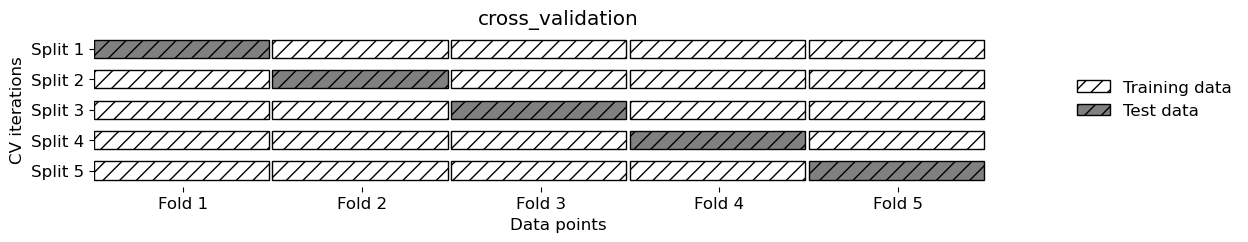

In [54]:
mglearn.plots.plot_cross_validation()

There is [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time series data. 

In [55]:
from sklearn.model_selection import TimeSeriesSplit

In [56]:
# Code from sklearn documentation
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_toy):
    print("%s %s" % (train, test))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


Let's try it out with Ridge on the bike rental data. 

In [57]:
lr = Ridge()

In [58]:
scores = cross_validate(
    lr, X_hour_week_onehot_poly, y, cv=TimeSeriesSplit(), return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002011,0.001003,0.642676,0.873182
1,0.003717,0.001010,0.828405,0.874305
2,0.001997,0.000000,0.773851,0.901262
3,0.001506,0.001009,0.696712,0.889429
4,0.003151,0.000000,0.892733,0.863889


<br><br><br><br>

## Forecasting further into the future

Recall that we are working with the bike rentals data from August 2015. 

In [59]:
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3h, Name: one, Length: 248, dtype: int64

Here is our data with lag features. 

In [60]:
rentals_lag5

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
...,...,...,...,...,...,...
2015-08-31 09:00:00,16,36.0,2.0,3.0,6.0,37.0
2015-08-31 12:00:00,8,16.0,36.0,2.0,3.0,6.0
2015-08-31 15:00:00,17,8.0,16.0,36.0,2.0,3.0


Let's impute the data and create `X` and `y`

In [61]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)

In [62]:
rentals_lag5_X = pd.DataFrame(X_lag_features_imp, columns=rentals_lag5.drop(columns=['n_rentals']).columns)
rentals_lag5_X.index = rentals_lag5.index
rentals_lag5_X

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,
2015-08-01 00:00:00,17.024291,17.004065,17.004082,17.040984,17.045267
2015-08-01 03:00:00,3.000000,17.004065,17.004082,17.040984,17.045267
2015-08-01 06:00:00,0.000000,3.000000,17.004082,17.040984,17.045267
2015-08-01 09:00:00,9.000000,0.000000,3.000000,17.040984,17.045267
2015-08-01 12:00:00,41.000000,9.000000,0.000000,3.000000,17.045267
...,...,...,...,...,...
2015-08-31 09:00:00,36.000000,2.000000,3.000000,6.000000,37.000000
2015-08-31 12:00:00,16.000000,36.000000,2.000000,3.000000,6.000000
2015-08-31 15:00:00,8.000000,16.000000,36.000000,2.000000,3.000000


In [63]:
rentals_lag5_y = rentals_lag5['n_rentals']

Let's split the data and train a linear model. 

In [64]:
# split the given features into a training and a test set
n_train = 184
X_train, X_test = rentals_lag5_X[:n_train], rentals_lag5_X[n_train:]
# also split the target array
y_train, y_test = rentals_lag5_y[:n_train], rentals_lag5_y[n_train:]

In [65]:
rentals_model = RandomForestRegressor(random_state=42)
rentals_model.fit(X_train, y_train);
print("Train-set R^2: {:.2f}".format(rentals_model.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(rentals_model.score(X_test, y_test)))

Train-set R^2: 0.94
Test-set R^2: 0.68


Given this, we can now predict `n_rentals` on the test data. 

In [66]:
X_test

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,
2015-08-24 00:00:00,12.0,31.0,58.0,30.0,23.0
2015-08-24 03:00:00,2.0,12.0,31.0,58.0,30.0
2015-08-24 06:00:00,3.0,2.0,12.0,31.0,58.0
2015-08-24 09:00:00,27.0,3.0,2.0,12.0,31.0
2015-08-24 12:00:00,6.0,27.0,3.0,2.0,12.0
...,...,...,...,...,...
2015-08-31 09:00:00,36.0,2.0,3.0,6.0,37.0
2015-08-31 12:00:00,16.0,36.0,2.0,3.0,6.0
2015-08-31 15:00:00,8.0,16.0,36.0,2.0,3.0


In [67]:
preds = rentals_model.predict(X_test)
preds

array([ 6.36,  4.73, 16.84,  8.71, 13.  , 24.34, 23.91, 12.07,  5.44,
        2.11, 42.31, 11.64, 28.09, 26.46, 25.41, 12.28, 11.89,  2.01,
       34.5 ,  8.34, 23.94, 25.2 , 26.63, 11.02,  2.67,  2.71, 26.72,
        9.96, 24.42, 23.05, 26.79, 14.17,  3.22,  1.51,  9.15,  8.83,
       21.12, 24.7 , 25.23, 10.04,  2.21,  2.29, 22.45, 28.03, 36.14,
       32.83, 21.45,  5.8 ,  3.43,  3.18, 21.72, 26.23, 40.37, 34.84,
       27.67, 14.79,  5.44,  4.45, 20.19, 14.49, 23.06, 20.34, 23.02,
       10.11])

In [68]:
X_test_preds = X_test.assign(predicted_n_rentals=preds)
X_test_preds = X_test_preds.assign(n_rentals=y_test)
X_test_preds.tail()

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5,predicted_n_rentals,n_rentals
starttime,,,,,,,
2015-08-31 09:00:00,36.0,2.0,3.0,6.0,37.0,14.49,16
2015-08-31 12:00:00,16.0,36.0,2.0,3.0,6.0,23.06,8
2015-08-31 15:00:00,8.0,16.0,36.0,2.0,3.0,20.34,17
2015-08-31 18:00:00,17.0,8.0,16.0,36.0,2.0,23.02,22
2015-08-31 21:00:00,22.0,17.0,8.0,16.0,36.0,10.11,7


- Ok, that is fine, but what if we want to predict 15 hours in the future? In other words, what if we want to predict number of rentals for the next three hours at time 2015-09-01 12:00:00?   
- Well, we would not have access to our lag features!! We don't yet know `n_rentals` for
    - 2015-09-01 00:00:00
    - 2015-09-01 03:00:00
    - 2015-09-01 06:00:00
    - 2015-09-01 09:00:00

There are a few approaches which could be employed:
1. Train a separate model for each number of 3-hour span. E.g. one model that predicts `n_rentals` for next three hours, another model that predicts `n_rentals` in six hours, etc. We can build these datasets.
2. Use a multi-output model that jointly predicts `n_rentalsIn3hours`, `n_rentalsIn6hours`, etc. However, multi-output models are outside the scope of CPSC 330. 
3. Use one model and sequentially predict using a `for` loop. 

If we decide to use approach 3, we would predict these values and then pretend they are true! For example, given that it's August 31st 2015 at 21:00. 

1. Predict `n_rentals` for September 1st 2015 at 00:00.
2. Then to predict `n_rentals` for September 1st 2015 at 03:00, we need to know `n_rentals` for September 1st 2015 at 00:00. Use our _prediction_ for September 1st 2015 at 00:00 as the truth.
3. Then, to predict `n_rentals` for September 1st 2015 at 06:00, we need to know `n_rentals` for September 1st 2015 at 00:00 and `n_rentals` for September 1st 2015 at 03:00. Use our predictions.
4. Etc etc.

<br><br><br><br>

### Forecasting further into the future on a retail dataset

Let's consider another time series dataset, [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) which is made available by the Federal Reserve Bank of St. Louis.

The dataset has dates and retail sales values corresponding to the dates. 

In [69]:
retail_df = pd.read_csv(DATA_DIR + "MRTSSM448USN.csv", parse_dates=["DATE"])
retail_df.columns = ["date", "sales"]

In [70]:
retail_df.head()

,date,sales
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


Let's examine the min and max dates in order to split the data. 

In [71]:
retail_df["date"].min()

Timestamp('1992-01-01 00:00:00')

In [72]:
retail_df["date"].max()

Timestamp('2022-09-01 00:00:00')

I'm considering everything upto 01 January 2016 as training data and everything after that as test data. 

In [73]:
retail_df_train = retail_df.query("date <= 20160101")
retail_df_test = retail_df.query("date >  20160101")

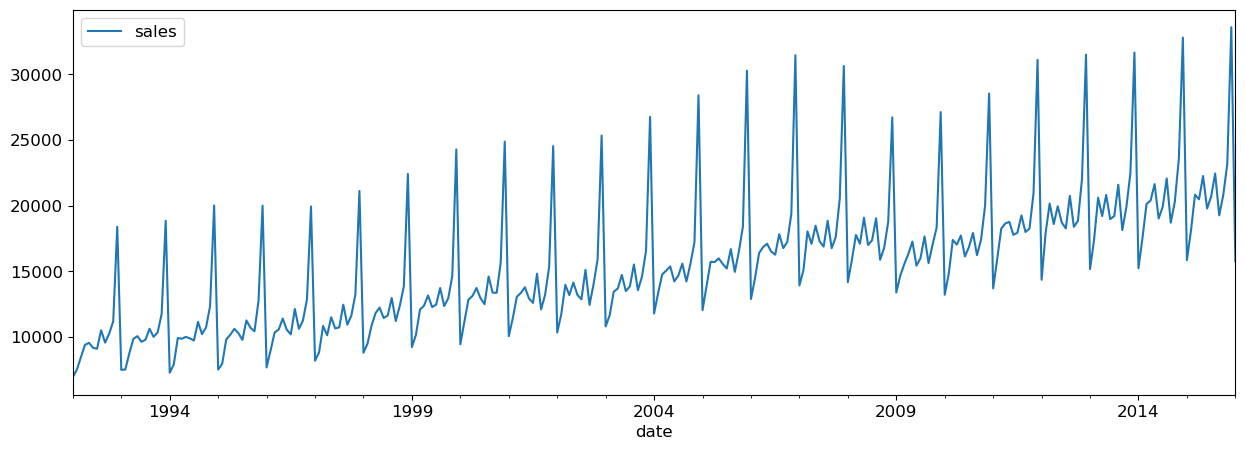

In [74]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

We can create a dataset using purely lag features.

In [75]:
def lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

Let's create lag features for the full dataframe. 

In [76]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])

In [77]:
retail_train_5 = retail_lag_5.query("date <= 20160101")
retail_test_5 = retail_lag_5.query("date >  20160101")
retail_train_5

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN
...,...,...,...,...,...,...,...
284,2015-09-01,19266,22452.0,20694.0,19781.0,22260.0,20485.0
285,2015-10-01,20794,19266.0,22452.0,20694.0,19781.0,22260.0
286,2015-11-01,23175,20794.0,19266.0,22452.0,20694.0,19781.0
287,2015-12-01,33590,23175.0,20794.0,19266.0,22452.0,20694.0


- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. I will just drop for convenience:

In [78]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

,sales,sales-1,sales-2,sales-3,sales-4,sales-5
5,9182,9558.0,9401.0,8475.0,7524.0,6938.0
6,9103,9182.0,9558.0,9401.0,8475.0,7524.0
7,10513,9103.0,9182.0,9558.0,9401.0,8475.0
8,9573,10513.0,9103.0,9182.0,9558.0,9401.0
9,10254,9573.0,10513.0,9103.0,9182.0,9558.0
...,...,...,...,...,...,...
284,19266,22452.0,20694.0,19781.0,22260.0,20485.0
285,20794,19266.0,22452.0,20694.0,19781.0,22260.0
286,23175,20794.0,19266.0,22452.0,20694.0,19781.0
287,33590,23175.0,20794.0,19266.0,22452.0,20694.0


In [79]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [80]:
retail_model = RandomForestRegressor(random_state=42)
retail_model.fit(retail_train_5_X, retail_train_5_y);
print("Train-set R^2: {:.2f}".format(retail_model.score(retail_train_5_X, retail_train_5_y)))

Train-set R^2: 0.96


Given this, we can now predict the sales

In [81]:
retail_test_5

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5
289,2016-02-01,19032,15775.0,33590.0,23175.0,20794.0,19266.0
290,2016-03-01,21581,19032.0,15775.0,33590.0,23175.0,20794.0
291,2016-04-01,20514,21581.0,19032.0,15775.0,33590.0,23175.0
292,2016-05-01,21774,20514.0,21581.0,19032.0,15775.0,33590.0
293,2016-06-01,20274,21774.0,20514.0,21581.0,19032.0,15775.0
...,...,...,...,...,...,...,...
364,2022-05-01,26831,25904.0,25622.0,20509.0,18113.0,39375.0
365,2022-06-01,25031,26831.0,25904.0,25622.0,20509.0,18113.0
366,2022-07-01,25214,25031.0,26831.0,25904.0,25622.0,20509.0
367,2022-08-01,26376,25214.0,25031.0,26831.0,25904.0,25622.0


In [82]:
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
preds

array([17896.8 , 21694.77, 21603.92, 21847.23, 21405.8 , 20564.86,
       22154.04, 26063.73, 21389.05, 22320.42, 30167.05, 16153.78,
       18096.6 , 20310.9 , 21353.73, 22826.97, 21697.73, 21549.23,
       21768.07, 27206.55, 21571.78, 22057.72, 28953.14, 16160.1 ,
       18000.99, 21596.28, 22910.96, 22225.52, 28327.52, 20620.57,
       22114.07, 30279.79, 21605.25, 21668.73, 18313.24, 16153.78,
       18245.22, 20319.6 , 23290.45, 22788.29, 28362.34, 22219.81,
       21530.08, 29881.14, 21617.54, 21670.38, 19380.36, 16157.83,
       18955.53, 22078.43, 13107.93, 11057.81, 10910.98, 15429.94,
       13255.13, 10868.94, 18311.55, 21274.73, 23902.03, 14813.7 ,
       17518.48, 18533.12, 30146.97, 29691.79, 15661.24, 27638.52,
       19365.48, 25176.  , 27021.21, 28854.11, 15915.6 , 16358.48,
       20334.54, 22550.67, 18116.77, 17144.95, 16533.7 , 25037.25,
       19365.48, 17205.11])

In [83]:
retail_test_5_preds = retail_test_5.assign(predicted_sales=preds)
retail_test_5_preds.tail()

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,predicted_sales
364,2022-05-01,26831,25904.0,25622.0,20509.0,18113.0,39375.0,17144.95
365,2022-06-01,25031,26831.0,25904.0,25622.0,20509.0,18113.0,16533.70
366,2022-07-01,25214,25031.0,26831.0,25904.0,25622.0,20509.0,25037.25
367,2022-08-01,26376,25214.0,25031.0,26831.0,25904.0,25622.0,19365.48
368,2022-09-01,23941,26376.0,25214.0,25031.0,26831.0,25904.0,17205.11


- Now what if we want to predict 5 months in the future? 
- We would not have access to our features!! We don't yet know the previous months sales, or two months prior! 

If we decide to use approach 3 from above, we would predict these values and then pretend they are true! For example, given that it's November 2022

1. Predict December 2022 sales
2. Then, to predict for January 2023, we need to know December 2022 sales. Use our _prediction_ for December 2022 as the truth.
3. Then, to predict for February 2023, we need to know December 2022 and January 2023 sales. Use our predictions.
4. Etc etc.

<br><br>

### Seasonality and trends 

- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

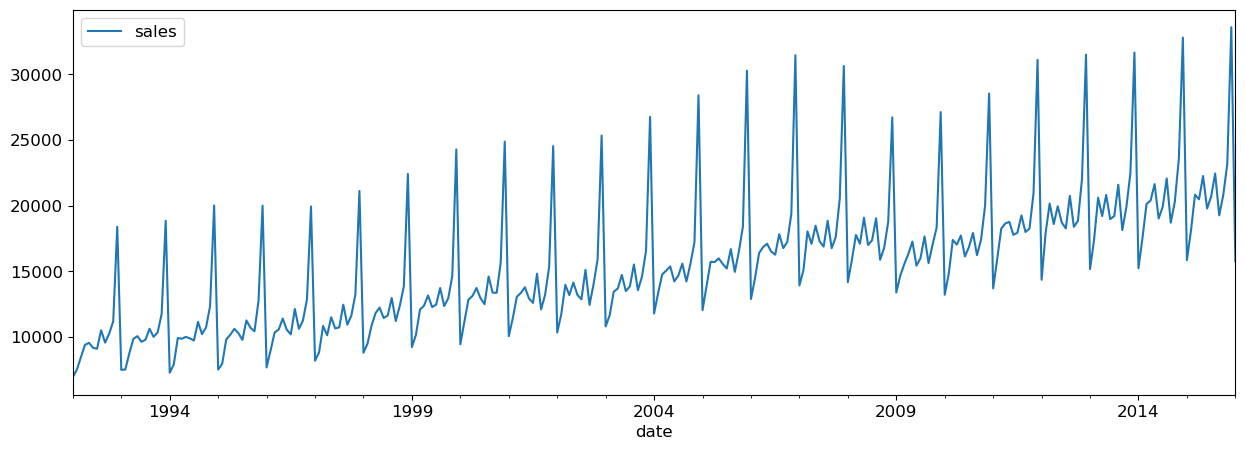

In [84]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

- It looks like there's a **trend** here - the sales are going up over time. 

Let's say we encoded the date as a feature in days like this:

In [85]:
retail_train_5_date = retail_lag_5.query("date <= 20160101")
first_day_retail = retail_train_5_date["date"].min()

retail_train_5_date = retail_train_5_date.assign(
    Days_since=retail_train_5_date["date"].apply(lambda x: (x - first_day_retail).days)
)
retail_train_5_date.head(10)

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,Days_since
0,1992-01-01,6938,NaN,NaN,NaN,NaN,NaN,0
1,1992-02-01,7524,6938.0,NaN,NaN,NaN,NaN,31
2,1992-03-01,8475,7524.0,6938.0,NaN,NaN,NaN,60
3,1992-04-01,9401,8475.0,7524.0,6938.0,NaN,NaN,91
4,1992-05-01,9558,9401.0,8475.0,7524.0,6938.0,NaN,121
5,1992-06-01,9182,9558.0,9401.0,8475.0,7524.0,6938.0,152
6,1992-07-01,9103,9182.0,9558.0,9401.0,8475.0,7524.0,182
7,1992-08-01,10513,9103.0,9182.0,9558.0,9401.0,8475.0,213
8,1992-09-01,9573,10513.0,9103.0,9182.0,9558.0,9401.0,244
9,1992-10-01,10254,9573.0,10513.0,9103.0,9182.0,9558.0,274


- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - Thus tree-based models cannot model trends.
  - This is really important to know!!
- Often, we model the trend separately and use the random forest to model a de-trended time series.

<br><br><br><br>

## Final remarks 

What did we not cover?

- A huge amount!

### Traditional time series approaches

- Time series analysis is a huge field of its own 
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We took different route in this course, and stick to our supervised learning tools.

### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.

### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 19), LSTMs, and non deep learning methods.
- Inference problems
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
  - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

### Other software package

- A good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).
- [sktime](https://www.sktime.net/en/stable/get_started.html)
    - Time series classification
    - forecasting
- [tslearn](https://tslearn.readthedocs.io/en/stable/)
    - classification
    - regression
    - clustering

### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.
